<a href="https://colab.research.google.com/github/mincfranc/DD_DataScience/blob/main/Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 5. Natural Language Processing

#Part 1) NLP-Based Similarity and Sentiment Analysis of Person Overviews

Aim:

-For user to pick any one person from list as input and output the 10 other people who's overview are "closest" to the person in a Natural Language Processing sense.

-Also output the sentiment of the overview of the person.

```
1. Imported my libraries & saved CSV file as dataframe
```

```
-pandas and numpy are used for data manipulation and working with arrays.
-nltk (Natural Language Toolkit) is used for text processing, including stopwords and sentiment analysis.
-TfidfVectorizer and NearestNeighbors from sklearn are used for text vectorization (converting text into numerical data)
and finding nearest neighbors based on that vectorization.
-TextBlob is used to perform sentiment analysis.
-re is used for regular expressions to clean the text data.
-nltk.download('stopwords') ensures the stopwords (common words like "the", "and", etc.) are downloaded and available.
-stop_words = set(stopwords.words('english')) creates a set of stopwords in English to filter out these words from the text.

```

In [1]:
#Part 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import re
from textblob import TextBlob
import random
import urllib.parse  # To handle URL decoding

pd.options.display.max_columns = 100



#Part 2
import requests
from textblob import TextBlob
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
nltk.download('vader_lexicon')  # Download VADER lexicon for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib as mpl

nltk.download('punkt_tab')





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
%%capture
# Install textblob
!pip install -U textblob
from textblob import TextBlob

In [3]:
%%capture
# Download corpora
!python -m textblob.download_corpora

In [4]:
%%capture output
#install Wikipedia API
!pip3 install wikipedia-api
import wikipediaapi

Data Collection: URL

In [5]:
url= "https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv"
nlp = pd.read_csv(url)
step1= nlp.copy()

Data Storage: Original dataframe "nlp" and working copy "step1"

In [6]:
nlp.info()
step1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42786 entries, 0 to 42785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     42786 non-null  object
 1   name    42786 non-null  object
 2   text    42786 non-null  object
dtypes: object(3)
memory usage: 1002.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42786 entries, 0 to 42785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     42786 non-null  object
 1   name    42786 non-null  object
 2   text    42786 non-null  object
dtypes: object(3)
memory usage: 1002.9+ KB


```
2. Reviewed data structure
```

Data Structure

* Cell content is object/string data type.

* "URI" column appears to be an ID and will not be used for vectorization, will use for Part 2

* "text" column to be used for vectorization

In [7]:
step1.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


* Shape: 3 columns, 42k+rows

* Zero nulls, Zero duplicates

In [8]:
print(step1.shape)
print(step1.columns)

print(step1.nunique())
print(step1.duplicated().value_counts())

print(step1.isnull().sum())

(42786, 3)
Index(['URI', 'name', 'text'], dtype='object')
URI     42786
name    42785
text    42786
dtype: int64
False    42786
Name: count, dtype: int64
URI     0
name    0
text    0
dtype: int64


```
3. Selected 20 random names from 'name' column using a controlled random process,
ensuring reproducibility with the seed_value.
  The comments indicate some seed_values I tried & included names I considered using.
```

In [9]:
import random

seed_value= 852  #can change number to reproduce different output
random.seed(seed_value)
all_names = step1['name'].tolist()
twnty_rnds = random.sample(all_names, 20)
twnty_rnds

# seed_value 1290- quasamodo
# 8300 - 'Gangsta Boo'
# 18624 - 'Helen Mirren'
# 361884 - 'Asaka Kubo'

# 'John Hobbs (baseball)' 852

['Jay Hein',
 'Red Grammer',
 'Professor Green',
 'Steve Yzerman',
 'Amir Kertes',
 'David McInerney',
 'John Hobbs (baseball)',
 'Mervyn Conn',
 'Larry Kilgore',
 'Mike Straka',
 'Clayton Spencer',
 'Joshua Trevi%C3%B1o',
 'Robert Hillary King',
 'Lucy Blackman',
 'Ryan North',
 'Lew Hunter',
 'Alan Foggon',
 'Per-Edvin Persson',
 'Steve McKevitt',
 'Paul Suttell']

```
4. Assigned all names from 'name' column to a list, then picked 20 random names without
repeating the picks.
   The comments indicate some names I considered selecting.
   ```

In [10]:
all_names =step1['name'].tolist()
randos = random.sample(all_names, 20) #will get different list each time
randos

# 'Sophie Evans (magician)'
# 'Claudia Carrasco'
# 'Bunny Matthews'

['Passion Yara',
 'John Sibbick',
 'Bertrand Lamarche',
 'Michal Kindred',
 'Thomas Downey',
 'Mustafa Hamsho',
 'Pratap Chatterjee',
 'Jonathan Castroviejo',
 'Kenneth McGriff',
 'Richard Cordray',
 'Karl Mildenberger',
 'Stanley F. Schmidt',
 'Katherine Benziger',
 'Carl Kurlander',
 'Giovanni Amighetti',
 'Paul Wotton',
 'William Haggas',
 'David Paton (ophthalmologist)',
 'Lynn Rogoff',
 'Peter Schwerdtfeger']

```
5. Searched names of people in my short list and their row number.
```

In [11]:
person = "John Hobbs (baseball)"
row_num = step1[step1['name'] == person].index[0]
person, row_num

('John Hobbs (baseball)', 39607)

```
6. Retrieved 'text' column for each person I wanted to look into by inputting their row number.
   The comments indicate the first sentence of person's text to decide my selection.
```

In [12]:
step1.iloc[8300]['text']

# iloc 9910- richard vincent bertollini american antisemite and white sup
# 8300 - rubi rubalcaba retired mexican luchador professional wrestler best known ring name adorable rub
# 42668 gangsta boo also known lady boo american rapper first female member memphis tennesseebased rap group three 6 mafia
# 'Asaka Kubo', 40399  lead vocal singer group ajyuc  posed primarily school uniforms underwear along usual gravure idol photosets also produced semi nude photograph collection
# 'Sophie Evans (magician)', 39766 english magician lives works mainly las vegas, also acts magic fire consultant
# Claudia Carrasco', 14245 beauty pageant titleholder crowned miss world peru 2009
#7539 richard van slater born may 19 1951 better known by his ring name dirty dick slater is a retired american professional wrestler who wrestled in the 1970s 1980s and mid1990s

'rubi rubalcaba born december 31 1931 is a retired mexican luchador or professional wrestler who is best known under the ring name adorable rub as adorable rub he was one of the pioneers of the exotico wrestling style mixing crossdressing with wrestling to create sexually ambiguous characters the adorable rub character was inspired by dizzy gardenia the first successful exotico character adorable rub sergio el hermoso and bello greco formed a group called ola lila the lilac wave who wrestled all over mexico of the three adorable rub saw the most success in the ring defeating cicln veloz jr to win the mexican national middleweight championship on april 6 1971 rub held the title for 196 days before losing the belt to anbal on june 28 1974 on february 27 1976 empresa mexicana de lucha libre emll bookers decided to make adorable rub the new nwa world light heavyweight champion emlls most prestigious championship rub defeated dr wagner for the title holding it for 231 days before losing the

In [13]:
#richard van slater born may 19 1951 better known by his ring name dirty dick slater is a retired american professional wrestler who wrestled in the 1970s 1980s and mid1990s for various promotions including midatlantic championship wrestling and world championship wrestling wcwslater began wrestling with mike graham at robinson high school in tampa florida he attended the university of tampa with paul orndorff from there he began wrestling in championship wrestling from florida and georgia championship wrestling he worked as a booker in knoxville tennessee after ron fuller sold his promotion to jim barnett he wrestled in midatlantic championship wrestling later world championship wrestling where he appeared on the first starrcade he also worked in midsouth wrestling association where he was managed by dark journey made some trips to the world wrestling council in puerto rico he wrestled briefly in the world wrestling federation as a babyface under a rebel gimmick but soon returned to wcw he wrestled there until receiving his back injury that ended his careerin june 2004 slater was convicted for the stabbing of his former girlfriend theresa halbert he was sentenced to one year of house arrest and two years of probation he blamed the incident on influence from painkillers

##Preprocessing
-Lowercasing
-Tokenizing
-Removing stopwords
-Removing non-alphanumeric characters

In [14]:
def preprocess_text(text):
    # Decode URL-encoded characters
    text = urllib.parse.unquote(text)  # Decode URL-encoded characters (e.g., %C3%A9 -> é)
    # Lowercase the text
    text = text.lower()
    # Remove unwanted characters: parentheses, special characters, punctuation
    text = re.sub(r"[^\w\s]", "", text)  # Remove anything that's not a word or whitespace
    text = re.sub(r"\(|\)", "", text)    # Remove leftover parentheses explicitly
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Preprocess the entire dataset
step1['text1'] = step1['text'].apply(preprocess_text)

# Apply to the 'name' column
step1['name1'] = step1['name'].apply(preprocess_text)


In [15]:
# Remove only < > from 'URI' column
step1['URI1'] = step1['URI'].str.replace(r"[<>]", "", regex=True)


In [16]:
# Create a new DataFrame called clean_df with the preprocessed columns and the original index
clean_df = step1[['name1', 'text1', 'URI1']].copy()

# Reset the index of clean_df to match the original step1 index
clean_df.index = step1.index

# Display the first few rows of clean_df to check the result
print(clean_df.head())

                 name1                                              text1  \
0        digby morrell  digby morrell born 10 october 1979 former aust...   
1        alfred j lewy  alfred j lewy aka sandy lewy graduated univers...   
2        harpdog brown  harpdog brown singer harmonica player active c...   
3  franz rottensteiner  franz rottensteiner born waidmannsfeld lower a...   
4                genka  henry krvits born 30 december 1974 tallinn bet...   

                                              URI1  
0        http://dbpedia.org/resource/Digby_Morrell  
1       http://dbpedia.org/resource/Alfred_J._Lewy  
2        http://dbpedia.org/resource/Harpdog_Brown  
3  http://dbpedia.org/resource/Franz_Rottensteiner  
4               http://dbpedia.org/resource/G-Enka  


In [17]:
clean_df['URI1']

,URI1
0,http://dbpedia.org/resource/Digby_Morrell
1,http://dbpedia.org/resource/Alfred_J._Lewy
2,http://dbpedia.org/resource/Harpdog_Brown
3,http://dbpedia.org/resource/Franz_Rottensteiner
4,http://dbpedia.org/resource/G-Enka
...,...
42781,http://dbpedia.org/resource/Motoaki_Takenouchi
42782,http://dbpedia.org/resource/Alan_Judge_(footba...
42783,http://dbpedia.org/resource/Eduardo_Lara
42784,http://dbpedia.org/resource/Tatiana_Faberg%C3%A9


In [18]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42786 entries, 0 to 42785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name1   42786 non-null  object
 1   text1   42786 non-null  object
 2   URI1    42786 non-null  object
dtypes: object(3)
memory usage: 1002.9+ KB


In [19]:
clean_df['name1'].tail()

,name1
42781,motoaki takenouchi
42782,alan judge footballer born 1960
42783,eduardo lara
42784,tatiana fabergé
42785,kenneth thomas


In [20]:
clean_df.columns

Index(['name1', 'text1', 'URI1'], dtype='object')

```
7. Assigned row search code to a variable to examine singularly.
```

###***The interactive portion starts here per Part 3 Aims.**

- Input a person's index # in first row and the remainder of the notebook will run vectorization, find nearest neighbors, calculate sentiment analyses for target and for nearest neighbors, plot it, rank nearness, and store results in new dataframe, per Part 1.

- It will also prompt completion of Part 2's Wikipedia Search Aims using the new dataframe.

In [21]:
person_index = 8300  # Replace with your desired index
person_text = clean_df.iloc[person_index]['text1']
person_name = clean_df.iloc[person_index]['name1']
person_text

'rubi rubalcaba born december 31 1931 retired mexican luchador professional wrestler best known ring name adorable rub adorable rub one pioneers exotico wrestling style mixing crossdressing wrestling create sexually ambiguous characters adorable rub character inspired dizzy gardenia first successful exotico character adorable rub sergio el hermoso bello greco formed group called ola lila lilac wave wrestled mexico three adorable rub saw success ring defeating cicln veloz jr win mexican national middleweight championship april 6 1971 rub held title 196 days losing belt anbal june 28 1974 february 27 1976 empresa mexicana de lucha libre emll bookers decided make adorable rub new nwa world light heavyweight champion emlls prestigious championship rub defeated dr wagner title holding 231 days losing belt carlos plata july 16 1976 october 7 1984 became second man hold mexican national cruiserweight championship defeated ngel blanco win title title would lose charro de jalisco 1986 long reti

In [22]:
print(person_name)

adorable rubí


```
  -I chose Rubi Rubalcaba row 8300
  ```

```
9. Calculated sentiment analysis on preprocessed text for target person variable.
```

In [23]:
person_feels = person_text
person_feels = TextBlob(person_feels).sentiment.polarity
person_feels

0.36756198347107444

In [24]:
person_feels1 = person_text
person_feels1 = TextBlob(person_feels1).sentiment
print(person_feels1)

Sentiment(polarity=0.36756198347107444, subjectivity=0.49869146005509646)


##Term Frequency-Inverse Document Frequency (TF-IDF)

```
10. Converted 'text' column data for clean_df and person variable into numerical vectors.
    and
    Compared person vector to clean_df['clean'] vectors.
```

In [25]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vec = tfidf_vectorizer.fit_transform(clean_df['text1'])
person_vec = tfidf_vectorizer.transform([person_text])

##Nearest Neighbors Model

```
11. Fit the NearestNeighbors model to analyze sentiment of specified overview
```

In [26]:
nn= NearestNeighbors(n_neighbors=11)
nn.fit(tfidf_vectorizer.transform(clean_df['text1']))

NearestNeighbors(n_neighbors=11)

```
12. Searched for nearest neighbors to target person by distance and corresponding row numbers.
```

In [27]:
#Find the nearest neighbors
distances, indices = nn.kneighbors(X=person_vec)

```
13. Extracted row numbers for the 10 nearest neighbors to target.
```

In [28]:
#Get the indices of the 10 nearest neighbors (excluding person)
nn_indices = indices[0][1:]

```
14. Extracted text descriptions of the 10 nearest neighbors from step1 df.
```

In [29]:
nn_text = clean_df['text1'].iloc[nn_indices].tolist()

## Output sentiment

```
15. Calculated Sentiment Analysis for 10 nearest neighbors

```

In [30]:
# Sentiment analysis for the 10 nearest neighbors
nn_feels1= nn_text
nn_feels1 = [TextBlob(text).sentiment for text in nn_text]
print(nn_feels1)

[Sentiment(polarity=0.15940719696969693, subjectivity=0.39582954545454546), Sentiment(polarity=-0.027857142857142855, subjectivity=0.3076190476190476), Sentiment(polarity=0.18224242424242423, subjectivity=0.3803636363636364), Sentiment(polarity=0.21625, subjectivity=0.40458333333333335), Sentiment(polarity=0.11346801346801347, subjectivity=0.23409090909090904), Sentiment(polarity=0.10219298245614032, subjectivity=0.35482456140350876), Sentiment(polarity=0.05343137254901961, subjectivity=0.385840874811463), Sentiment(polarity=0.14835145474680358, subjectivity=0.4071755763616228), Sentiment(polarity=0.19938016528925617, subjectivity=0.348258559622196), Sentiment(polarity=0.06743777056277056, subjectivity=0.2781655844155844)]


In [31]:
nn_feels = [TextBlob(text).sentiment.polarity for text in nn_text]
nn_feels

[0.15940719696969693,
 -0.027857142857142855,
 0.18224242424242423,
 0.21625,
 0.11346801346801347,
 0.10219298245614032,
 0.05343137254901961,
 0.14835145474680358,
 0.19938016528925617,
 0.06743777056277056]

```
16. Classified polarity as Positive, Negative or Neutral.
```

In [32]:
# Define a function to classify sentiment based on polarity
def classify_feels(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply classification to the nn_feels list
nn_feels_class = [classify_feels(feel) for feel in nn_feels]


```
17. Created df with nearest neighbors sentiment class
```

In [33]:
# Create a DataFrame for the nearest neighbors' text, polarity, api wikipedia, and classification
nn_feels_df = pd.DataFrame({
    'index': nn_indices,  # Indices of the neighbors
    'name': clean_df['name1'].iloc[nn_indices].tolist(),
    'sentiment_polarity': nn_feels,  # Polarity values
    'sentiment_class': nn_feels_class,  # Classified sentiments
    'text': nn_text,  # Text of the neighbors
    'wiki_page': clean_df['URI1'].iloc[nn_indices].tolist()
})
nn_feels_df.head(10)

,index,name,sentiment_polarity,sentiment_class,text,wiki_page
0,42506,cosmo baker,0.159407,positive,cosmo baker new york based dj music producer t...,http://dbpedia.org/resource/Cosmo_Baker
1,7539,dick slater,-0.027857,negative,richard van slater born may 19 1951 better kno...,http://dbpedia.org/resource/Dick_Slater
2,9483,ricky blues,0.182242,positive,william perry blake iii better known ring name...,http://dbpedia.org/resource/Ricky_Blues
3,20060,pedro morales,0.216250,positive,pedro morales born october 22 1942 retired pue...,http://dbpedia.org/resource/Pedro_Morales
4,40587,knuckles nelson,0.113468,positive,brendan higgins born september 26 1963 best kn...,http://dbpedia.org/resource/Knuckles_Nelson
5,38612,gino martino,0.102193,positive,john ferraro born november 28 american profess...,http://dbpedia.org/resource/Gino_Martino
6,3743,drew mcintyre,0.053431,positive,andrew drew galloway born 6 june 1985 scottish...,http://dbpedia.org/resource/Drew_McIntyre
7,42747,jason rumble,0.148351,positive,jason dellagatta born 1971 american profession...,http://dbpedia.org/resource/Jason_Rumble
8,32251,road dogg,0.199380,positive,brian girard bg james born may 20 1969 america...,http://dbpedia.org/resource/Road_Dogg
9,610,gary michael cappetta,0.067438,positive,gary michael cappetta born december 12 1952 am...,http://dbpedia.org/resource/Gary_Michael_Cappetta


In [34]:
nn_feels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               10 non-null     int64  
 1   name                10 non-null     object 
 2   sentiment_polarity  10 non-null     float64
 3   sentiment_class     10 non-null     object 
 4   text                10 non-null     object 
 5   wiki_page           10 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 608.0+ bytes


```
18. Created df for target person with sinlge row and 5 columns to match nearest neighbors df.
```

In [35]:
# Create a DataFrame for target person with single row
target_feels_df = pd.DataFrame({
    'index': [person_index],  # Index of the target person
    'name': [person_name],  # Name of the target person
    'sentiment_polarity': [TextBlob(person_text).sentiment.polarity],  # Polarity for target
    'sentiment_class': [classify_feels(TextBlob(person_text).sentiment.polarity)],  # Class for target
    'text': [person_text],  # Text for target
    'wiki_page': [clean_df.iloc[person_index]['URI1']]  # Wiki page for target
})

```
19. Concatenated target and nearest neighbor data for Scatterplot
```

In [36]:
# Concatenate target person's data with nearest neighbors' data
nn_feels_df1 = pd.concat([target_feels_df, nn_feels_df], ignore_index=True)
# 'sentiment_polarity' 'index' 'sentiment_class'
nn_feels_df1[['name', 'wiki_page']].head(11)

,name,wiki_page
0,adorable rubí,http://dbpedia.org/resource/Adorable_Rub%C3%AD
1,cosmo baker,http://dbpedia.org/resource/Cosmo_Baker
2,dick slater,http://dbpedia.org/resource/Dick_Slater
3,ricky blues,http://dbpedia.org/resource/Ricky_Blues
4,pedro morales,http://dbpedia.org/resource/Pedro_Morales
5,knuckles nelson,http://dbpedia.org/resource/Knuckles_Nelson
6,gino martino,http://dbpedia.org/resource/Gino_Martino
7,drew mcintyre,http://dbpedia.org/resource/Drew_McIntyre
8,jason rumble,http://dbpedia.org/resource/Jason_Rumble
9,road dogg,http://dbpedia.org/resource/Road_Dogg


In [37]:
nn_feels_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               11 non-null     int64  
 1   name                11 non-null     object 
 2   sentiment_polarity  11 non-null     float64
 3   sentiment_class     11 non-null     object 
 4   text                11 non-null     object 
 5   wiki_page           11 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 656.0+ bytes


```
20. Processed data further given difficulty returning target's data in nn_feels_df1.

(index # 8300)
```

In [38]:
def title_case_name(name):
    """Converts a name to title case and replaces underscores between first and last name with a space."""
    # Replace underscores with spaces and convert to title case
    name = name.replace("_", " ").title()
    # Handle special cases like "Mc" or "Mac"
    name = re.sub(r"\b(Mc|Mac)(\w)", lambda m: m.group(1) + m.group(2).upper(), name)
    return name

nn_feels_df1['name'] = nn_feels_df1['name'].apply(title_case_name)

###Scatterplot of Person's Sentiment Scores

```
21. Scatterplot of nn_feels_df1.
```

<Figure size 800x600 with 0 Axes>

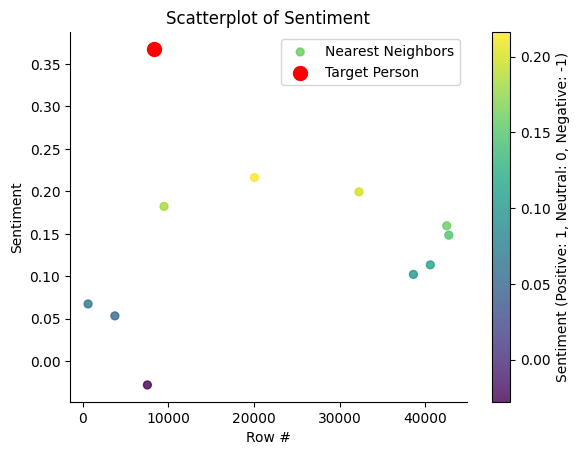

In [39]:
target_index = nn_feels_df1[nn_feels_df1['name'] == title_case_name(person_name)].index[0]

plt.figure(figsize=(8, 6))

# Plot nearest neighbors without colorbar
scatter = nn_feels_df1[nn_feels_df1.index != target_index].plot(kind='scatter', x='index', y='sentiment_polarity', s=32, alpha=.8, c='sentiment_polarity', cmap='viridis', label='Nearest Neighbors', colorbar=False)
# Plot target person
plt.scatter(nn_feels_df1.loc[target_index, 'index'], nn_feels_df1.loc[target_index, 'sentiment_polarity'], color='red', s=100, label='Target Person')
plt.xlabel('Row #')
plt.ylabel('Sentiment')
plt.title('Scatterplot of Sentiment')
# Create a single colorbar for the 'viridis' colormap
plt.colorbar(scatter.collections[0], label='Sentiment (Positive: 1, Neutral: 0, Negative: -1)')
# plt.ylim(0.0, nn_feels_df1['sentiment_polarity'].max() + 0.2)  # Adjust '0.1' if needed
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend()
plt.show()

```
22. Scatterplot of nn_feels_df1 zoomed out.
```

<Figure size 800x600 with 0 Axes>

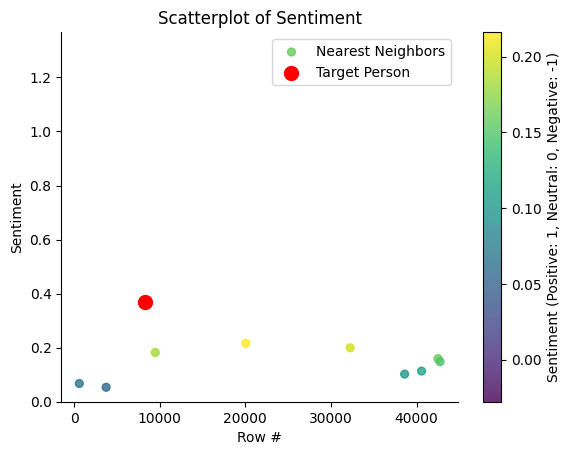

In [40]:
target_index = nn_feels_df1[nn_feels_df1['name'] == title_case_name(person_name)].index[0]

plt.figure(figsize=(8, 6))

# Plot nearest neighbors without colorbar
scatter = nn_feels_df1[nn_feels_df1.index != target_index].plot(kind='scatter', x='index', y='sentiment_polarity', s=32, alpha=.8, c='sentiment_polarity', cmap='viridis', label='Nearest Neighbors', colorbar=False)
# Plot target person
plt.scatter(nn_feels_df1.loc[target_index, 'index'], nn_feels_df1.loc[target_index, 'sentiment_polarity'], color='red', s=100, label='Target Person')
plt.xlabel('Row #')
plt.ylabel('Sentiment')
plt.title('Scatterplot of Sentiment')
# Create a single colorbar for the 'viridis' colormap
plt.colorbar(scatter.collections[0], label='Sentiment (Positive: 1, Neutral: 0, Negative: -1)')
plt.ylim(0.0, nn_feels_df1['sentiment_polarity'].max() + 1.0)  # Adjust '0.1' if needed
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend()
plt.show()

```
23. Ranked nearness to target.

```

In [41]:
#Rank nearness by sorting df by sentiment polarity in descending order
ranked_df = nn_feels_df1.sort_values(by=['sentiment_polarity'], ascending=False)

# Display the ranked df
print(ranked_df[['name', 'sentiment_polarity', 'sentiment_class']])
ranked_df

                     name  sentiment_polarity sentiment_class
0           Adorable Rubí            0.367562        positive
4           Pedro Morales            0.216250        positive
9               Road Dogg            0.199380        positive
3             Ricky Blues            0.182242        positive
1             Cosmo Baker            0.159407        positive
8            Jason Rumble            0.148351        positive
5         Knuckles Nelson            0.113468        positive
6            Gino Martino            0.102193        positive
10  Gary Michael Cappetta            0.067438        positive
7           Drew McIntyre            0.053431        positive
2             Dick Slater           -0.027857        negative


,index,name,sentiment_polarity,sentiment_class,text,wiki_page
0,8300,Adorable Rubí,0.367562,positive,rubi rubalcaba born december 31 1931 retired m...,http://dbpedia.org/resource/Adorable_Rub%C3%AD
4,20060,Pedro Morales,0.216250,positive,pedro morales born october 22 1942 retired pue...,http://dbpedia.org/resource/Pedro_Morales
9,32251,Road Dogg,0.199380,positive,brian girard bg james born may 20 1969 america...,http://dbpedia.org/resource/Road_Dogg
3,9483,Ricky Blues,0.182242,positive,william perry blake iii better known ring name...,http://dbpedia.org/resource/Ricky_Blues
1,42506,Cosmo Baker,0.159407,positive,cosmo baker new york based dj music producer t...,http://dbpedia.org/resource/Cosmo_Baker
8,42747,Jason Rumble,0.148351,positive,jason dellagatta born 1971 american profession...,http://dbpedia.org/resource/Jason_Rumble
5,40587,Knuckles Nelson,0.113468,positive,brendan higgins born september 26 1963 best kn...,http://dbpedia.org/resource/Knuckles_Nelson
6,38612,Gino Martino,0.102193,positive,john ferraro born november 28 american profess...,http://dbpedia.org/resource/Gino_Martino
10,610,Gary Michael Cappetta,0.067438,positive,gary michael cappetta born december 12 1952 am...,http://dbpedia.org/resource/Gary_Michael_Cappetta
7,3743,Drew McIntyre,0.053431,positive,andrew drew galloway born 6 june 1985 scottish...,http://dbpedia.org/resource/Drew_McIntyre


#Part 2) Wikipedia



Aim

-For user to access entire content of a person's (from Step 1) Wikipedia page using Wikipedia API

-For the person's Wikipedia page to determine the sentiment of the entire page

-Print out the Wikipedia article

-Collect the Wikipedia pages from 10 nearest neighbors in Step 1

-Determine the nearness ranking of these 10 to your main subject based on their entire Wikipedia page

-Compare the nearest ranking from Step 1) with the Wikipedia page nearness ranking

```
1. Find wikipedia page for nn_feels_df1
```

##Preprocessing

ENCOUNTERED SO MANY ISSUES BECAUSE OF HIS NAME IN WIKIPEDIA Adorable_Rub%C3%AD

- Went back to Part 1 and changed the last df 'name' to title case and it worked for Part 1.

- Unscrambled columns 'name' and 'wiki_page'.

In [42]:
#Unscramble person's name and return with appropriate text to assist in search
nn_feels_df1['name'] = nn_feels_df1['name'].apply(urllib.parse.unquote)
nn_feels_df1['name']

,name
0,Adorable Rubí
1,Cosmo Baker
2,Dick Slater
3,Ricky Blues
4,Pedro Morales
5,Knuckles Nelson
6,Gino Martino
7,Drew McIntyre
8,Jason Rumble
9,Road Dogg


In [43]:
#Unscramble data in wikipedia API and return with appropriate text to assist in search
nn_feels_df1['wiki_page'] = nn_feels_df1['wiki_page'].apply(urllib.parse.unquote)
nn_feels_df1['wiki_page']

,wiki_page
0,http://dbpedia.org/resource/Adorable_Rubí
1,http://dbpedia.org/resource/Cosmo_Baker
2,http://dbpedia.org/resource/Dick_Slater
3,http://dbpedia.org/resource/Ricky_Blues
4,http://dbpedia.org/resource/Pedro_Morales
5,http://dbpedia.org/resource/Knuckles_Nelson
6,http://dbpedia.org/resource/Gino_Martino
7,http://dbpedia.org/resource/Drew_McIntyre
8,http://dbpedia.org/resource/Jason_Rumble
9,http://dbpedia.org/resource/Road_Dogg


#TF-IDF & Nearest Neighbors Model of Wikipedia page

```
2. Processed and extracted wikipedia data for target and nearest neighbors
to analyze via TF-IDF, and created dataframe.
```

Preprocessed and stored wikipedia content in dataframe.

In [44]:
nn_feels_df1.columns

Index(['index', 'name', 'sentiment_polarity', 'sentiment_class', 'text',
       'wiki_page'],
      dtype='object')

In [45]:
# Initialize Wikipedia API
wikip = wikipediaapi.Wikipedia(user_agent='foobar')

def process_wiki_text(wiki_page_title, person_name):
    """Clean and preprocess Wikipedia content."""
    try:
        # Fetch Wikipedia page content
        page_ex = wikip.page(wiki_page_title)
        wiki_text = page_ex.text

        # Check if Wikipedia text is empty
        if not wiki_text.strip():
            print(f"Skipping '{person_name}' due to empty Wikipedia content.")
            return None

        # Clean the Wikipedia text by removing newlines
        wiki_text_clean = wiki_text.replace("\n", " ")

        return wiki_text_clean

    except Exception as e:
        print(f"Error fetching Wikipedia content for '{person_name}': {e}")
        return None

# Create a new dataframe from nn_feels_df1 with original columns plus the cleaned wiki_content
all_wiki_data = []
for index, row in nn_feels_df1.iterrows():
    person_name = row['name']
    wiki_page_title = row['wiki_page'].split('/')[-1]

    wiki_content_clean = process_wiki_text(wiki_page_title, person_name)

    if wiki_content_clean is not None:
        all_wiki_data.append({
            'index': row['index'],
            'name': row['name'],
            'sentiment_polarity': row['sentiment_polarity'],
            'sentiment_class': row['sentiment_class'],
            'text': row['text'],
            'wiki_page': row['wiki_page'],
            'wiki_content': wiki_content_clean
        })

# Store the result in combined_wiki_df
combined_wiki_df = pd.DataFrame(all_wiki_data)

# Display the dataframe with cleaned Wikipedia content
combined_wiki_df.head()


,index,name,sentiment_polarity,sentiment_class,text,wiki_page,wiki_content
0,8300,Adorable Rubí,0.367562,positive,rubi rubalcaba born december 31 1931 retired m...,http://dbpedia.org/resource/Adorable_Rubí,"Ruben Carbajal Lopez (December 31, 1931 – June..."
1,42506,Cosmo Baker,0.159407,positive,cosmo baker new york based dj music producer t...,http://dbpedia.org/resource/Cosmo_Baker,Cosmo Baker is an East Coast based American DJ...
2,7539,Dick Slater,-0.027857,negative,richard van slater born may 19 1951 better kno...,http://dbpedia.org/resource/Dick_Slater,"Richard Van Slater (May 19, 1951 – October 18,..."
3,9483,Ricky Blues,0.182242,positive,william perry blake iii better known ring name...,http://dbpedia.org/resource/Ricky_Blues,"William Perry Blake III, better known by the r..."
4,20060,Pedro Morales,0.216250,positive,pedro morales born october 22 1942 retired pue...,http://dbpedia.org/resource/Pedro_Morales,"Pedro Antonio Morales (October 22, 1942 – Febr..."


In [63]:
# --- Sentiment Analysis Setup ---
sia = SentimentIntensityAnalyzer()

# Function to classify sentiment based on compound score
def get_sentiment_class(polarity_score):
    """Classify sentiment based on compound score."""
    if polarity_score >= 0.05:
        return "positive"
    elif polarity_score <= -0.05:
        return "negative"
    else:
        return "neutral"

# --- Perform TF-IDF on the cleaned 'wiki_content' ---
tfidf2_vectorizer = TfidfVectorizer(stop_words='english')
tfidf2_matrix = tfidf_vectorizer.fit_transform(combined_wiki_df['wiki_content'])
tfidf2_data = tfidf2_matrix.toarray().tolist()
combined_wiki_df['tfidf_matrix_wiki'] = tfidf2_data



# --- Sentiment Analysis on each 'wiki_content' ---
def get_sentiment_polarity(text):
    """Get sentiment polarity score using VADER."""
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis to the 'wiki_content' and add the sentiment columns
combined_wiki_df['sentiment_polarity'] = combined_wiki_df['wiki_content'].apply(get_sentiment_polarity)
combined_wiki_df['sentiment_class'] = combined_wiki_df['sentiment_polarity'].apply(get_sentiment_class)

# --- Finding Nearest Neighbors ---
# Select a target person
target_person_index = 0 # Change this to the index of the target person
target_vector = tfidf2_matrix[target_person_index]

# Calculate cosine similarity
similarities = cosine_similarity(target_vector, tfidf2_matrix)

# Find nearest neighbors
num_neighbors = 10
wiki_neighbor_indices = similarities.argsort()[0][-num_neighbors - 1:-1][::-1]

# Extract neighbor information from the original df, ensuring original columns
wiki_neighbors = combined_wiki_df.iloc[wiki_neighbor_indices][['index', 'name', 'sentiment_polarity', 'sentiment_class', 'text', 'wiki_page', 'tfidf_matrix_wiki']]

wiki_neighbors = wiki_neighbors.sort_values(by='sentiment_polarity', ascending=False)

# --- Output the nearest neighbors with sentiment
print(f"Nearest Neighbors to #{combined_wiki_df.iloc[target_person_index]['index']} {combined_wiki_df.iloc[target_person_index]['name']} ({combined_wiki_df.iloc[target_person_index]['sentiment_polarity']}):")
# for index, row in nearest_neighbors.iterrows():
#     print(f"- {row['name']}, Sentiment: {row['sentiment_class']} ({row['sentiment_polarity']})")

# Ensure the final output matches the desired structure
wiki_neighbors[['index', 'name', 'sentiment_polarity', 'sentiment_class']]


Nearest Neighbors to #8300 Adorable Rubí (0.9992):


,index,name,sentiment_polarity,sentiment_class
4,20060,Pedro Morales,1.0000,positive
8,42747,Jason Rumble,0.9999,positive
7,3743,Drew McIntyre,0.9999,positive
2,7539,Dick Slater,0.9999,positive
6,38612,Gino Martino,0.9994,positive
3,9483,Ricky Blues,0.9977,positive
5,40587,Knuckles Nelson,0.9973,positive
10,610,Gary Michael Cappetta,0.9833,positive
1,42506,Cosmo Baker,0.9746,positive
9,32251,Road Dogg,0.9216,positive


###Scatterplot of Wikipedia Sentiment scores

```
3. Scatterplot of target and nearest neighbors Sentiment from Wikipedia API.
```



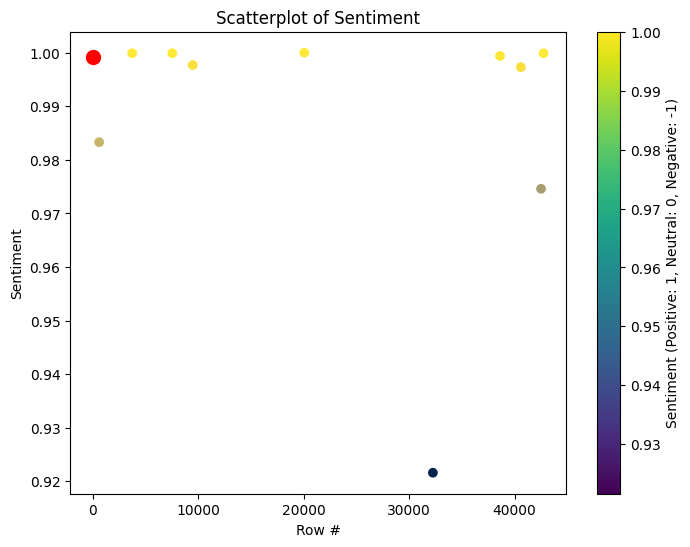

In [47]:
plt.figure(figsize=(8, 6))
wiki_plot = plt.scatter(wiki_neighbors['index'], wiki_neighbors['sentiment_polarity'], c=wiki_neighbors['sentiment_polarity'], cmap='cividis', label= 'Nearest Wiki Neighbors')
target_person = combined_wiki_df.iloc[[target_person_index]]
plt.scatter(target_person.index, target_person['sentiment_polarity'], color='red', label='Target', s=100)
plt.xlabel('Row #')
plt.ylabel('Sentiment')
plt.title('Scatterplot of Sentiment')

# Create a ScalarMappable for the colorbar
norm = plt.Normalize(wiki_neighbors['sentiment_polarity'].min(), wiki_neighbors['sentiment_polarity'].max()) # Normalize data range
cmap = plt.get_cmap('viridis') # Choose a colormap

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm) # Use mpl.cm to access the ScalarMappable
sm.set_array([])  # This line is important to prevent an error

# Add the colorbar using the ScalarMappable and specify the scatter plot for location
plt.colorbar(sm, ax=wiki_plot.axes, label='Sentiment (Positive: 1, Neutral: 0, Negative: -1)')  # Pass ax argument to specify location

plt.show()

# plt.colorbar(label='Sentiment (Positive: 1, Neutral: 0, Negative: -1)')
# plt.show()

#Part 3) Interactive Notebook


Make an interactive notebook. **See Part 1) Preprocessing

In addition to presenting the project slides, at the end of the presentation each student will demonstrate their code using a famous person suggested by the other students that exists in the DBpedia set.

###Ranking Comparison of Nearest Neighbors to Target

1. "Pedro Morales" ranks the closest to Adorable Rub in Part 1 (0.216520 polarity) and Part 2 (1.0) as the closest neighbor in sentiment per their wikipedia page.
2. "Dick Slater" ranks #4 and with "positive" class in Part 2 despite being classified as "negative" in Part 1 with the lowest raw score (-0.027857).
3. Part 2 uses relative closeness to "Adorable Rubí," leading to high sentiment similarity scores even for entities like "Dick Slater," whose sentiment is classified as "negative" in Table 1.
4. Part 1 (Original Sentiment Polarity) presents the raw values, offering a broader range of sentiments and more precise classifications.
3. All entries are marked "positive" in Part 2, even though Part 1 categorizes "Dick Slater" as "negative."
This flip in presentation emphasizes that Nearest Neighbors in Part 2 focuses on relative similarity, while Part 1 (Original Sentiment Polarity) reflects actual sentiment scores.

In [48]:
# # Pull out the Adorable_Rubí (alt 0237) from wikipedia - http://dbpedia.org/resource/Adorable_Rub%C3%AD
# topic = 'Adorable_Rubí'
# wikip = wikipediaapi.Wikipedia(user_agent = 'foobar')
# page_ex = wikip.page(topic)
# wiki_text0 = page_ex.text
# wiki_text0


In [49]:
# # Pull out the Adorable_Rubí (alt 0237) from wikipedia - http://dbpedia.org/resource/Adorable_Rub%C3%AD
# topic = 'Cosmo_Baker'
# wikip = wikipediaapi.Wikipedia(user_agent = 'foobar')
# page_ex = wikip.page(topic)
# wiki_text1 = page_ex.text
# wiki_text1

In [50]:
# # Replace newline chars with spaces before doing any processing. Strip the ' and "s" from possessives
# wiki_text0_clean = (
#     wiki_text0
#     .replace("\n"," ")
#     .replace("'s",'')
#     .replace("'",'')
# )
# wiki_text0_clean

In [51]:
# wiki_text0_clean = wiki_text0.lower()
# for c in ["\n", "'s", "'", "  "]:
#   wiki_text0_clean = wiki_text0_clean.replace(c," ")
# wiki_text0_clean

In [52]:
# pat = re.compile(r"(\n|'s|'| )+")
# wiki_text0_clean = re.sub(pat,' ', wiki_text0.lower())
# wiki_text0_clean

In [53]:
# # Break up single string into separate sentences
# wiki_blob = TextBlob(wiki_text0_clean)
# len(wiki_blob.sentences)


In [54]:
# topic_sentences = wiki_blob.sentences[0:5]
# topic_sentences

In [55]:
# # Convert text blob sentences to strings
# topic_sentences_str = [ str(x) for x in topic_sentences ]
# topic_sentences_str


In [56]:
# # Perform the TF-IDF Vectorization
# tf_idf_vec = TfidfVectorizer(stop_words = 'english')
# tf_idf_pop = tf_idf_vec.fit_transform(topic_sentences_str)
# tf_idf_pop.shape


In [57]:
# tf_idf_vec.get_feature_names_out()

In [58]:
# # Print out results in a dataframe
# tf_df = pd.DataFrame(tf_idf_pop.toarray(), columns = tf_idf_vec.get_feature_names_out())
# tf_df.transpose()

In [59]:
# # Get a data frame with the TF-IDF values sorted for document 0
# df1 = pd.DataFrame(tf_idf_pop[0].T.todense(), index=tf_idf_vec.get_feature_names_out(), columns=['TF-IDF'])
# df = df1.sort_values('TF-IDF', ascending=False)
# df

In [60]:
# tf_df = pd.DataFrame(
#        tf_idf_pop.toarray(),
#        columns=tf_idf_vec.get_feature_names_out(),
#        index=range(len(topic_sentences_str))  # Add sentence index as index
#    )

# tf_df['sentence'] = topic_sentences_str
# tf_df.head()

In [61]:
# df1.columns

In [62]:
# (
# tf_idf_pop[0]
# .T
# .todense()
# )